In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import gym
import torch
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
server = 'mssql-2017.labs.wmi.amu.edu.pl'
database = 'db_football_players'
username = 'db_football_players'
password = 'Lh4M466Ww7'

connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

ModuleNotFoundError: No module named 'pyodbc'

In [3]:
class GradientClippingCallback(BaseCallback):
    def __init__(self, clip_value=0.5, verbose=0):
        super(GradientClippingCallback, self).__init__(verbose)
        self.clip_value = clip_value

    def _on_step(self):
        torch.nn.utils.clip_grad_norm_(self.model.policy.parameters(), self.clip_value)
        return True

In [4]:
def evaluate_sensitivity(model, environment, feature_indices):
    original_state = environment.reset()
    print("Original state shape:", original_state.shape)
    sensitivities = []
    for idx in feature_indices:
        if idx >= original_state.shape[0]:
            print(f"Index {idx} is out of bounds for the state with shape {original_state.shape}")
            continue
        perturbed_state = np.copy(original_state)
        perturbation = 0.01 * (np.max(original_state) - np.min(original_state))
        perturbed_state[idx] += perturbation
        action, _states = model.predict(original_state, deterministic=True)
        perturbed_action, _ = model.predict(perturbed_state, deterministic=True)
        sensitivity = np.abs(action - perturbed_action)
        sensitivities.append(sensitivity)
    return sensitivities


In [5]:
class TransferEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data):
        super(TransferEnv, self).__init__()
        self.data = data
        self.action_space = gym.spaces.Discrete(len(data['team'].unique()))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32)

        self.state = self.reset()

    def validate_observations(self, obs):
        if np.isnan(obs).any():
            print("NaN detected in observations")
            obs = np.nan_to_num(obs)
        return obs

    def reset(self):
        self.current_step = 0
        obs = self.data.iloc[self.current_step].values
        return self.validate_observations(obs)

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.data)
        reward = self.calculate_reward(action)
        if not done:
            next_state = self.data.iloc[self.current_step].values
        else:
            next_state = np.zeros_like(self.data.iloc[0].values)
        return self.validate_observations(next_state), reward, done, {}

    def calculate_reward(self, action):
        if self.current_step == 0:
            return 0
        else:
            previous_value = self.data.iloc[self.current_step - 1]['marketValue']
            current_value = self.data.iloc[self.current_step]['marketValue']
            reward = current_value - previous_value
            return reward

    def render(self, mode='human', close=False):
        pass

In [10]:
def convert_season(season):
    start, end = season.split('/')

    if int(start) >= 25:
        start = '19' + start
    else:
        start = '20' + start

    if int(end) >= 25:
        end = '19' + end
    else:
        end = '20' + end


    return f"{start}/{end}"
def assign_season(date):
    if date.month < 8:
        return f"{date.year-1}/{date.year}"
    else:
        return f"{date.year}/{date.year+1}"

def generate_value_season(df_player_values):
    df_player_values['date'] = pd.to_datetime(df_player_values['date'], format='%d.%m.%Y', errors='coerce')
    df_player_values['season'] = df_player_values['date'].apply(assign_season)
    return df_player_values

def load_data():

 query_player_seasons = """
 SELECT * FROM [db_football_players].[dbo].[player_seasons]
 """
 df_player_seasons = pd.read_sql(query_player_seasons, engine)

 query_player_values = """
 SELECT * FROM [db_football_players].[dbo].[player_value]
 """
 df_player_values = pd.read_sql(query_player_values, engine)

 query_player_flags = """
 SELECT * FROM [db_football_players].[dbo].[player_flags]
 """
 df_player_flags = pd.read_sql(query_player_flags, engine)

 query_player_transfers = """
 SELECT * FROM [db_football_players].[dbo].[transfers]
 """
 df_player_transfers = pd.read_sql(query_player_transfers, engine)

 query_player_players = """
 SELECT * FROM [db_football_players].[dbo].[players]
 """
 df_player_players = pd.read_sql(query_player_players, engine)

 return df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players

In [114]:
df_player_seasons, df_player_values, df_player_flags, df_player_transfers, df_player_players = load_data()
df_player_values = generate_value_season(df_player_values)
df_player_transfers['season'] = df_player_transfers['season'].apply(convert_season)
result = pd.merge(df_player_flags, df_player_players, on='id')
result = pd.merge(result, df_player_values, on=['id','season'])
result = pd.merge(result, df_player_transfers, on=['id', 'season'])
label_encoders = {}
file=pd.read_csv('elo_combined_updated_manual_v2.csv').drop(columns=['elo_ranking_club']).rename(columns={"club": "team",})
manual_elo_values = {
    'Legia Warszawa': 2057.30,
    'Rakow Czestochowa': 2056.73,
    'Lech Poznan': 2028.27,
    'Jagiellonia Bialystok': 2010.47,
    'Pogon Szczecin': 1979.33,
    'Slask Wroclaw': 1936.03,
    'Piast Gliwice': 1934.58,
    'Cracovia Krakow': 1908.82,
    'Zaglebie Lubin': 1898.70,
    'Gornik Zabrze': 1891.41,
    'Korona Kielce': 1886.56,
    'Radomiak Radom': 1852.95,
    'Widzew Lodz': 1851.43,
    'Ruch Chorzow': 1829.66,
    'Warta Poznan': 1813.30,
    'Puszcza Niepolomice': 1804.84,
    'Stal Mielec': 1764.82,
    'LKS Lodz': 1729.92,
    'Arka Gdynia': 1874.70,
    'Lechia Gdansk': 1836.87,
    'Wisla Krakow': 1834.11,
    'GKS Katowice': 1785.84,
    'Wisla Plock': 1769.47,
    'Motor Lublin': 1766.02,
    'GKS Tychy': 1737.78,
    'Miedz Legnica': 1734.90,
    'LKS Nieciecza': 1722.74,
    'Gornik Leczna': 1696.46,
    'Odra Opole': 1691.37,
    'Polonia Warszawa': 1652.76,
    'Znicz Pruszkow': 1649.86,
    'Resovia Rzeszow': 1646.33,
    'Podbeskidzie Bielsko Biala': 1637.50,
    'Chrobry Glogow': 1636.25,
    'Stal Rzeszow': 1606.55,
    'Zaglebie Sosnowiec': 1572.21,
    'Pogon Siedlce': 1628.91,
    'Kotwica Kolobrzeg': 1618.69,
    'Stal Stalowa Wola': 1613.80,
    'KKS 1925 Kalisz': 1587.47,
    'Olimpia Grudziadz': 1578.32,
    'Chojniczanka Chojnice': 1573.93,
    'Hutnik Krakow': 1566.19,
    'SKRA Czestochowa': 1565.43,
    'Polonia Bytom': 1561.88,
    'Wisla Pulawy': 1548.34,
    'Olimpia Elblag': 1541.09,
    'Stomil Olsztyn': 1511.45,
    'GKS Jastrzebie': 1509.57,
    'Lech Poznan II': 1505.25,
    'Sandecja Nowy Sacz': 1501.80,
    'Lks Lodz II': 1493.72,
    'Zaglebie Lubin II': 1493.26,
    'Radunia Stezyca': 1489.67
}
for club, elo in manual_elo_values.items():
    file.loc[file['team'] == club, 'elo'] = elo
result= pd.merge(result, file, on=['team'])
result.to_csv('football_players_data.csv')
for column in [ 'season', 'team', 'RED_CARD_PLAYER', 'VALUE_FLAG', 'ZERO_EXP',
    'ALWAYS_ON_BENCH', 'PROGRESS_SINCE_NEW_TEAM',
    'SAME_RESULTS_FOR_LONG_TIME', 'YELLOW_CARD_PLAYER', 'place_of_birth', 'birth_date', 'nationality','position',
    'manager', 'club', 'fee','clubName1', 'clubName2']:
    le = LabelEncoder()
    result[column] = le.fit_transform(result[column])
    label_encoders[column] = le
result = result.sort_values(by=['id', 'season'])

# Utworzenie kolumny z poprzednią wartością
result['previous_market_value'] = result.groupby('id')['marketValue'].shift(1)

# Usuwanie wierszy bez poprzedniej wartości
result['previous_market_value'] = result['previous_market_value'].fillna(result['marketValue'])

target = result['marketValue']
result['height'] = result['height'].fillna(1.80)
features = result.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2','value', 'club'])
features2 = result.drop(columns=['slug', 'name', 'date_x', 'date_y'])

unique_ids = result['id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

train_data = result[result['id'].isin(train_ids)]
test_data = result[result['id'].isin(test_ids)]

X_train = train_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_train = train_data['marketValue']
X_test = test_data.drop(columns=['marketValue','slug', 'name', 'date_x', 'date_y','place_of_birth', 'manager','clubName1', 'clubName2', 'value', 'club'])
y_test = test_data['marketValue']
#X_train = X_train.select_dtypes(exclude=['datetime'])
#X_test = X_test.select_dtypes(exclude=['datetime'])
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions  = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

                        team      elo
596      Manchester City U23  2634.42
1316         Manchester City  2634.42
2308              FC Arsenal  2598.95
1672            FC Liverpool  2548.55
530      Bayer 04 Leverkusen  2509.13
2298       VfB Stuttgart U19  2403.35
1665           VfB Stuttgart  2403.35
446         VfB Stuttgart II  2403.35
2075          FC Chelsea U21  2393.80
2334          Chelsea FC U23  2393.80
2309          Inter Mediolan  2386.52
1392             Real Madryt  2372.98
1663  RasenBallsport Leipzig  2366.41
225        Tottenham Hotspur  2359.11
1704   Newcastle United Jets  2355.34
1691            FC Barcelona  2347.18
379           FC Barcelona B  2347.18
1879        Bayern Monachium  2345.28
1103  FC Paris Saint-Germain  2336.42
1532         Atletico Madryt  2330.52
188              Sporting CP  2328.60
2041       PSV Eindhoven U19  2304.80
1666           PSV Eindhoven  2304.80
955        PSV Eindhoven U21  2304.80
245           Crystal Palace  2301.80
1617        

previous_market_value    0.711783
fee                      0.059060
elo                      0.032234
season                   0.028527
nationality              0.027303
id                       0.024851
height                   0.023651
birth_date               0.022592
team                     0.017754
age                      0.017615
dtype: float64


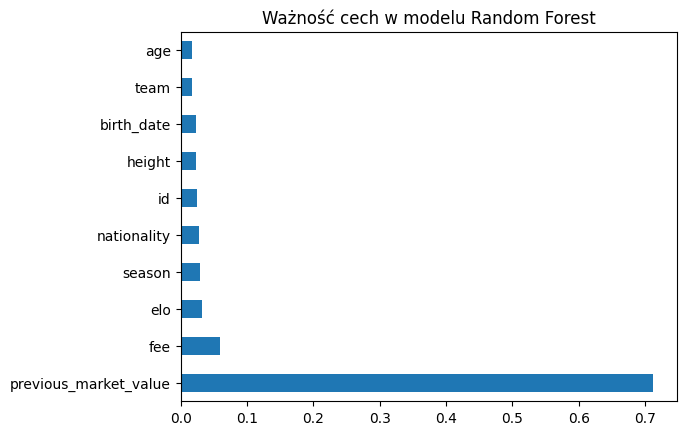

In [113]:
if isinstance(features, pd.DataFrame):
    feature_names = features.columns.tolist()
else:
    feature_names = features
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
print(feat_importances.nlargest(10))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Ważność cech w modelu Random Forest')
plt.show()


object
int32


ValueError: You are trying to merge on int32 and object columns for key 'team'. If you wish to proceed you should use pd.concat

In [73]:


ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(features2), columns=features2.columns)

data = df_scaled
env = TransferEnv(data)


model_rl = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0001)
model_rl.learn(total_timesteps=20000, callback=GradientClippingCallback(clip_value=0.5))
feature_indices = range(len(features))
sensitivities = evaluate_sensitivity(model_rl, env, feature_indices)
print("Feature sensitivities:", sensitivities)


   # env = TransferEnv(model, result, features)
    #model_rl = PPO("MlpPolicy", env, verbose=1)

obs = env.reset()
for _ in range(1000):
    action, _states = model_rl.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(f"Action taken: {action}, Reward received: {rewards}")
    if dones:
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\JaSzw\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 979  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 458         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014724997 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.74       |
|    explained_variance   | -0.0944     |
|    learning_rate        | 0.0001      |
|    loss                 | 1.15        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0546     |
|    value_loss           | 1.9         |
-----------------------------------------
----------------------------------

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Index 181709 is out of bounds for the state with shape (24,)
Index 181710 is out of bounds for the state with shape (24,)
Index 181711 is out of bounds for the state with shape (24,)
Index 181712 is out of bounds for the state with shape (24,)
Index 181713 is out of bounds for the state with shape (24,)
Index 181714 is out of bounds for the state with shape (24,)
Index 181715 is out of bounds for the state with shape (24,)
Index 181716 is out of bounds for the state with shape (24,)
Index 181717 is out of bounds for the state with shape (24,)
Index 181718 is out of bounds for the state with shape (24,)
Index 181719 is out of bounds for the state with shape (24,)
Index 181720 is out of bounds for the state with shape (24,)
Index 181721 is out of bounds for the state with shape (24,)
Index 181722 is out of bounds for the state with shape (24,)
Index 181723 is out of bounds for the state with shape (24,)
Index 181724 is out of bounds for the state with shape (24,)
Index 181725 is out of b

In [81]:
print(label_encoders)
club_encoder = label_encoders['team']
print(club_encoder)
inverse_club_mapping = {index: label for index, label in enumerate(club_encoder.classes_)}

for i in range(1000):
    action, _states = model_rl.predict(obs)
    action = action.item() 
    club_name = inverse_club_mapping[action]
    print(f"Action taken: {action} Proposed club: {club_name}")
    obs, rewards, dones, info = env.step(action)
    if dones:
        break

{'season': LabelEncoder(), 'team': LabelEncoder(), 'RED_CARD_PLAYER': LabelEncoder(), 'VALUE_FLAG': LabelEncoder(), 'ZERO_EXP': LabelEncoder(), 'ALWAYS_ON_BENCH': LabelEncoder(), 'PROGRESS_SINCE_NEW_TEAM': LabelEncoder(), 'SAME_RESULTS_FOR_LONG_TIME': LabelEncoder(), 'YELLOW_CARD_PLAYER': LabelEncoder(), 'place_of_birth': LabelEncoder(), 'birth_date': LabelEncoder(), 'nationality': LabelEncoder(), 'position': LabelEncoder(), 'manager': LabelEncoder(), 'club': LabelEncoder(), 'fee': LabelEncoder(), 'clubName1': LabelEncoder(), 'clubName2': LabelEncoder()}
LabelEncoder()
Action taken: 3408 Proposed club: Legia II
Action taken: 178 Proposed club: AKA Salzb. U16
Action taken: 5419 Proposed club: Sundowns
Action taken: 1853 Proposed club: FC Dila Gori
Action taken: 2976 Proposed club: Inter Bratislava
Action taken: 2062 Proposed club: FC Serpa
Action taken: 2554 Proposed club: Galatasaray
Action taken: 3672 Proposed club: Marseille B
Action taken: 354 Proposed club: Al-Fayha
Action taken: 3